The final questionnaire consists of 25 questions

In [3]:
import pandas as pd
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.feature_selection import mutual_info_classif
import joblib

In [4]:
# load the screening questionnaire 
screening_questions = pd.read_csv('screening_questions_final.csv', sep=';')

# load adhd dataset
df = pd.read_csv('questionnaire_dataset.csv', sep=';')
feature_cols = desired_columns = ['gender', 'group'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
df = df[feature_cols].copy()

# oversampling
adasyn = ADASYN(random_state=38)
X = df.copy().drop(columns=['gender'])
y = df['gender'].copy() # men = 1 / women = 0
X_balanced, y_balanced = adasyn.fit_resample(X, y)
balanced_df = pd.concat([y_balanced, X_balanced], axis=1)
balanced_df.describe()

# split the dataset by gender 
balanced_df_women = balanced_df[balanced_df['gender'] == 0]
balanced_df_men = balanced_df[balanced_df['gender'] == 1]

# split it further into features and target variable
X_women = balanced_df_women.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_women = balanced_df_women['group'].copy() # adhd = 1 / no adhd = -1

X_men = balanced_df_men.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_men = balanced_df_men['group'].copy() # adhd = 1 / no adhd = -1

# further filter the features to extract only the ones in the narrowed down version of the questionnaire
screening_qs_codes = screening_questions['question_code'].unique()
X_women = X_women.filter(items=screening_qs_codes, axis=1)
X_men = X_men.filter(items=screening_qs_codes, axis=1)

# stratified splitting to preserve a balanced class split according to diagnosis
# women
X_train_val_women, X_test_women, y_train_val_women, y_test_women = train_test_split(X_women, y_women, test_size=0.2, stratify=y_women, random_state=15) 
X_train_women, X_val_women, y_train_women, y_val_women = train_test_split(X_train_val_women, y_train_val_women, test_size=0.35, stratify=y_train_val_women, random_state=15) 

# men
X_train_val_men, X_test_men, y_train_val_men, y_test_men = train_test_split(X_men, y_men, test_size=0.2, stratify=y_men, random_state=15) 
X_train_men, X_val_men, y_train_men, y_val_men = train_test_split(X_train_val_men, y_train_val_men, test_size=0.35, stratify=y_train_val_men, random_state=15) 

In [5]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2, scoring='accuracy')
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

Best performing models on 25 question questionnaire

Random Forest for Women

In [6]:
# best parameters for women
rf_women = RandomForestClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=10, random_state=15)

rf_women.fit(X_train_val_women, y_train_val_women)
rf_women_perm_importance = permutation_importance(rf_women, X_test_women, y_test_women, n_repeats=30, random_state=15)

feature_importance_df_women = pd.DataFrame({
    'question_code': X_train_val_women.columns,
    'feature_importance': rf_women_perm_importance.importances_mean
})

merged_df_women = pd.merge(screening_questions, feature_importance_df_women, on='question_code', how='inner').sort_values(by='feature_importance', ascending=False)
merged_df_women = merged_df_women.drop(columns=['Critère DSM-5']).copy()
merged_df_women.head(25)

,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category,feature_importance
19,I find it hard to stay in place when the situa...,tr33,Often unable to play or engage in leisure acti...,hyperactivity/impulsivity,0.060185
4,My relatives blame me for not listening to the...,tr7,Often does not seem to listen when spoken to d...,inattention,0.034259
5,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention,0.018519
6,I have difficulty complying with instructions,tr9,Often does not follow through on instructions ...,inattention,0.016667
8,I have difficulty organizing my time,tr12,Often has difficulty organizing tasks and acti...,inattention,0.016667
22,I find it difficult to wait my turn in a conve...,tr40,Often blurts out an answer before a question h...,hyperactivity/impulsivity,0.012963
10,I tend to avoid tasks that require sustained m...,tr15,"Often avoids, dislikes, or is reluctant to eng...",inattention,0.007407
20,My entourage finds me difficult to follow.,tr34,"Is often “on the go,” acting as if “driven by ...",hyperactivity/impulsivity,0.006481
0,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention,0.000000
15,I am often subject to forgetfulness in my dail...,tr24,"Is often forgetful in daily activities (e.g., ...",inattention,0.000000


In [7]:
# save the model to a file
joblib.dump(rf_women, 'rf_women.pkl')

['rf_women.pkl']

,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category,feature_importance
5,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention,0.164246
19,I find it hard to stay in place when the situa...,tr33,Often unable to play or engage in leisure acti...,hyperactivity/impulsivity,0.145193
20,My entourage finds me difficult to follow.,tr34,"Is often “on the go,” acting as if “driven by ...",hyperactivity/impulsivity,0.112533
15,I am often subject to forgetfulness in my dail...,tr24,"Is often forgetful in daily activities (e.g., ...",inattention,0.102589
10,I tend to avoid tasks that require sustained m...,tr15,"Often avoids, dislikes, or is reluctant to eng...",inattention,0.082895
8,I have difficulty organizing my time,tr12,Often has difficulty organizing tasks and acti...,inattention,0.069549
18,I have trouble sitting still,tr27,Often fidgets with or taps hands or feet or sq...,hyperactivity/impulsivity,0.059143
6,I have difficulty complying with instructions,tr9,Often does not follow through on instructions ...,inattention,0.057204
12,I am easily distracted by my environment,tr21,Is often easily distracted by extraneous stimu...,inattention,0.031709
21,I tend to monopolize conversations.,tr37,Often talks excessively.,hyperactivity/impulsivity,0.031438


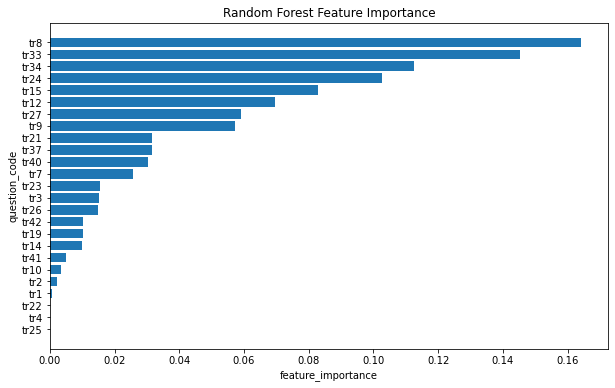

In [8]:
feature_importances_rf_women = rf_women.feature_importances_
feature_importance_df_rf_women = pd.DataFrame({'question_code': X_train_val_women.columns, 'feature_importance': feature_importances_rf_women})
feature_importance_df_rf_women = feature_importance_df_rf_women.sort_values(by='feature_importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_rf_women['question_code'], feature_importance_df_rf_women['feature_importance'])
plt.xlabel('feature_importance')
plt.ylabel('question_code')
plt.title('Random Forest Feature Importance')

feature_importance_df_rf_women.sort_values(by='feature_importance', ascending=False)

merged_df_feat_imp_women = pd.merge(screening_questions, feature_importance_df_rf_women, on='question_code', how='inner').sort_values(by='feature_importance', ascending=False)
merged_df_feat_imp_women = merged_df_feat_imp_women.drop(columns=['Critère DSM-5']).copy()
merged_df_feat_imp_women.head(25)

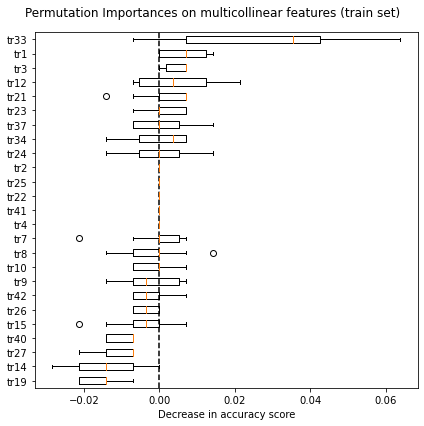

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_permutation_importance(rf_women, X_train_val_women, y_train_val_women, ax)
ax.set_xlabel("Decrease in accuracy score")
fig.suptitle("Permutation Importances on multicollinear features (train set)")
_ = fig.tight_layout()

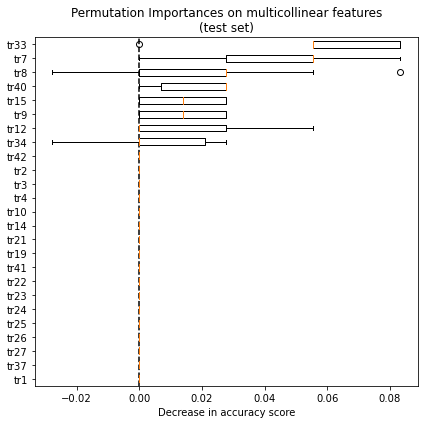

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_permutation_importance(rf_women, X_test_women, y_test_women, ax)
ax.set_title("Permutation Importances on multicollinear features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

In [11]:
# Initialize a SHAP explainer object
explainer = shap.TreeExplainer(rf_women, X_train_val_women)

# Calculate SHAP values for the test set
shap_values_women = explainer.shap_values(X_test_women)

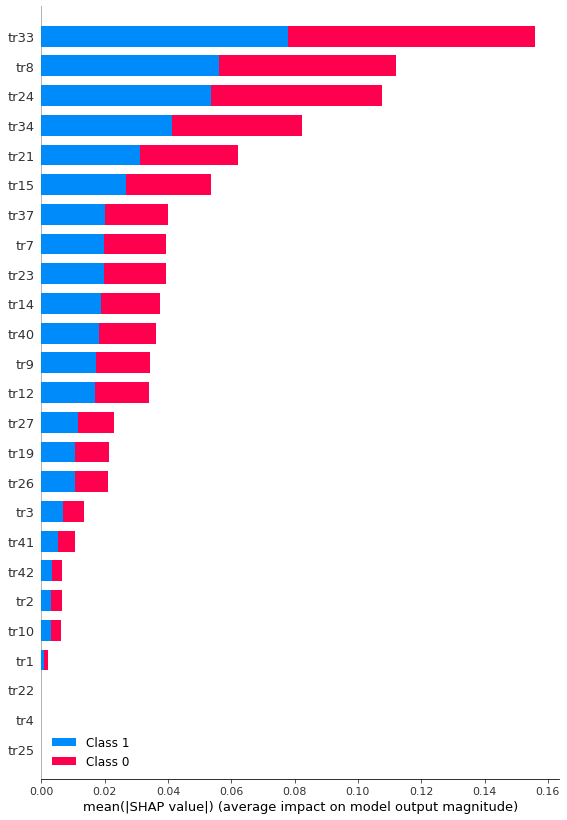

In [12]:
# Visualize the SHAP values
shap.summary_plot(shap_values_women, X_test_women, max_display=25)

In [13]:
np.abs(shap_values_women).shape
aggs = np.abs(shap_values_women).mean(1)

shap_values_women_df = pd.DataFrame(aggs.T) 

shap_values_women_df['feature_importance'] = shap_values_women_df[0] + shap_values_women_df[1]
shap_values_women_df['question_code'] = X_test_women.columns
shap_values_women_df = shap_values_women_df.drop(columns=[0, 1]).sort_values(by='feature_importance', ascending=False)

shap_merged_df_women = pd.merge(screening_questions, shap_values_women_df, on='question_code', how='inner').sort_values(by='feature_importance', ascending=False)
shap_merged_df_women = shap_merged_df_women.drop(columns=['Critère DSM-5']).copy()
shap_merged_df_women.head(20)

,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category,feature_importance
19,I find it hard to stay in place when the situa...,tr33,Often unable to play or engage in leisure acti...,hyperactivity/impulsivity,0.155843
5,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention,0.111961
15,I am often subject to forgetfulness in my dail...,tr24,"Is often forgetful in daily activities (e.g., ...",inattention,0.107515
20,My entourage finds me difficult to follow.,tr34,"Is often “on the go,” acting as if “driven by ...",hyperactivity/impulsivity,0.082358
12,I am easily distracted by my environment,tr21,Is often easily distracted by extraneous stimu...,inattention,0.062174
10,I tend to avoid tasks that require sustained m...,tr15,"Often avoids, dislikes, or is reluctant to eng...",inattention,0.053552
21,I tend to monopolize conversations.,tr37,Often talks excessively.,hyperactivity/impulsivity,0.040084
4,My relatives blame me for not listening to the...,tr7,Often does not seem to listen when spoken to d...,inattention,0.039404
14,I am easily distracted by what is going on aro...,tr23,Is often easily distracted by extraneous stimu...,inattention,0.039344
9,It is difficult for me to organize tasks that ...,tr14,Often has difficulty organizing tasks and acti...,inattention,0.037597


In [14]:
# mutual information
importances = []
features = []

mutual_info_women = mutual_info_classif(X_train_val_women, y_train_val_women)
for importance, feature in sorted(zip(mutual_info_women, X_train_val_women.columns), reverse=True):
    importances.append(importance)
    features.append(feature)

mutual_info_df_women = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

mutual_info_df_women

,Feature,Importance
0,tr33,0.332769
1,tr24,0.286346
2,tr8,0.234963
3,tr34,0.193322
4,tr12,0.193126
5,tr4,0.189770
6,tr22,0.188100
7,tr14,0.185262
8,tr21,0.172623
9,tr9,0.170219


Random Forest for Men

In [15]:
rf_men = RandomForestClassifier(criterion='entropy', max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=20)
rf_men.fit(X_train_val_men, y_train_val_men)

rf_men_perm_importance = permutation_importance(rf_men, X_train_val_men, y_train_val_men, n_repeats=30, random_state=15)

feature_importance_df_men = pd.DataFrame({
    'question_code': X_train_val_men.columns,
    'feature_importance': rf_men_perm_importance.importances_mean
})
merged_df_men = pd.merge(screening_questions, feature_importance_df_men, on='question_code', how='inner').sort_values(by='feature_importance', ascending=False)
merged_df_men = merged_df_men.drop(columns=['Critère DSM-5']).copy()
merged_df_men.head(25)

,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category,feature_importance
20,My entourage finds me difficult to follow.,tr34,"Is often “on the go,” acting as if “driven by ...",hyperactivity/impulsivity,0.059441
2,I often make careless mistakes in my activities,tr3,Often fails to give close attention to details...,inattention,0.041259
21,I tend to monopolize conversations.,tr37,Often talks excessively.,hyperactivity/impulsivity,0.031235
17,I often wiggle my hands or feet on my seat,tr26,Often fidgets with or taps hands or feet or sq...,hyperactivity/impulsivity,0.010956
0,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention,0.009091
10,I tend to avoid tasks that require sustained m...,tr15,"Often avoids, dislikes, or is reluctant to eng...",inattention,0.005594
12,I am easily distracted by my environment,tr21,Is often easily distracted by extraneous stimu...,inattention,0.005594
16,I often have trouble meeting my obligations (a...,tr25,"Is often forgetful in daily activities (e.g., ...",inattention,0.003730
15,I am often subject to forgetfulness in my dail...,tr24,"Is often forgetful in daily activities (e.g., ...",inattention,0.002797
23,It is difficult for me to wait my turn in a qu...,tr41,Often has difficulty waiting his or her turn (...,hyperactivity/impulsivity,0.000000


In [16]:
# save the model to a file
joblib.dump(rf_men, 'rf_men.pkl')

['rf_men.pkl']

,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category,feature_importance
2,I often make careless mistakes in my activities,tr3,Often fails to give close attention to details...,inattention,0.180071
20,My entourage finds me difficult to follow.,tr34,"Is often “on the go,” acting as if “driven by ...",hyperactivity/impulsivity,0.104039
0,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention,0.099574
12,I am easily distracted by my environment,tr21,Is often easily distracted by extraneous stimu...,inattention,0.075742
11,I often lose things I need for my work,tr19,Often loses things necessary for tasks or acti...,inattention,0.067631
22,I find it difficult to wait my turn in a conve...,tr40,Often blurts out an answer before a question h...,hyperactivity/impulsivity,0.062972
9,It is difficult for me to organize tasks that ...,tr14,Often has difficulty organizing tasks and acti...,inattention,0.053012
15,I am often subject to forgetfulness in my dail...,tr24,"Is often forgetful in daily activities (e.g., ...",inattention,0.052643
17,I often wiggle my hands or feet on my seat,tr26,Often fidgets with or taps hands or feet or sq...,hyperactivity/impulsivity,0.040470
5,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention,0.037133


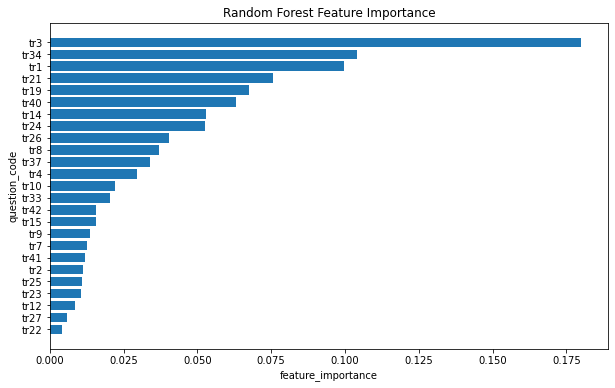

In [17]:
feature_importances_rf_men = rf_men.feature_importances_
feature_importance_df_rf_men = pd.DataFrame({'question_code': X_train_val_men.columns, 'feature_importance': feature_importances_rf_men})
feature_importance_df_rf_men = feature_importance_df_rf_men.sort_values(by='feature_importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_rf_men['question_code'], feature_importance_df_rf_men['feature_importance'])
plt.xlabel('feature_importance')
plt.ylabel('question_code')
plt.title('Random Forest Feature Importance')

feature_importance_df_rf_men.sort_values(by='feature_importance', ascending=False)

merged_df_feat_imp_men = pd.merge(screening_questions, feature_importance_df_rf_men, on='question_code', how='inner').sort_values(by='feature_importance', ascending=False)
merged_df_feat_imp_men = merged_df_feat_imp_men.drop(columns=['Critère DSM-5']).copy()
merged_df_feat_imp_men.head(25)

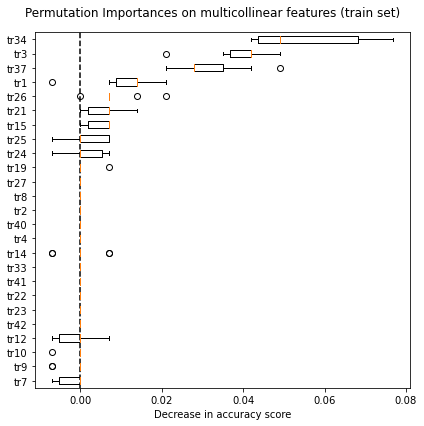

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_permutation_importance(rf_men, X_train_val_men, y_train_val_men, ax)
ax.set_xlabel("Decrease in accuracy score")
fig.suptitle("Permutation Importances on multicollinear features (train set)")
_ = fig.tight_layout()

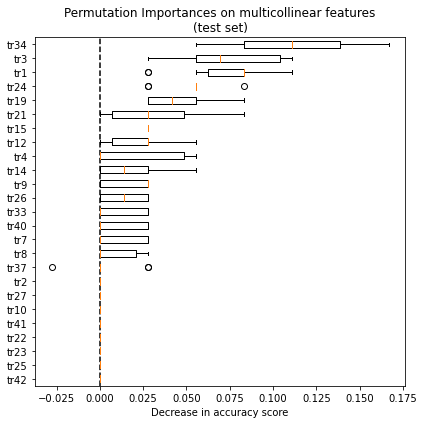

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_permutation_importance(rf_men, X_test_men, y_test_men, ax)
ax.set_title("Permutation Importances on multicollinear features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

In [20]:
# Initialize a SHAP (SHapley Additive exPlanations) explainer object
explainer = shap.TreeExplainer(rf_men, X_train_val_men)

# Calculate SHAP values for the test set
shap_values_men = explainer.shap_values(X_test_men)

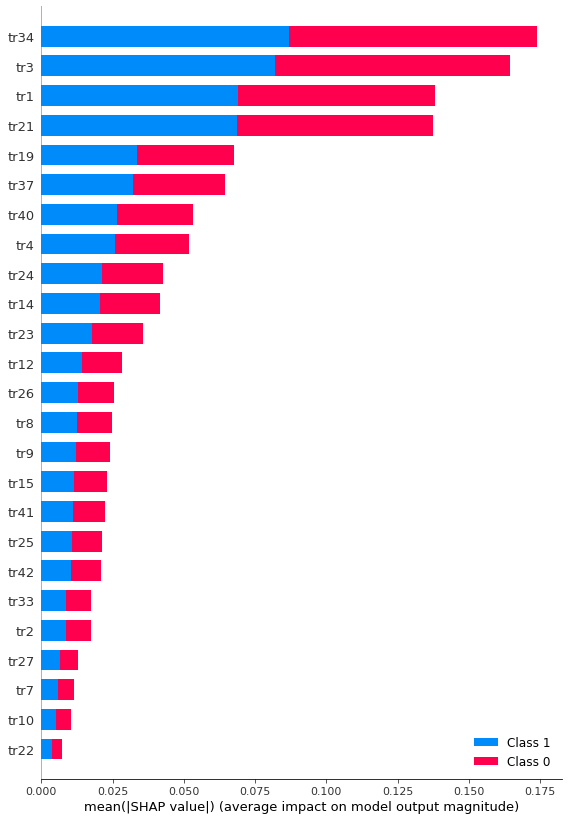

In [21]:
# Visualize the SHAP values
shap.summary_plot(shap_values_men, X_test_men, max_display=25)

In [22]:
np.abs(shap_values_men).shape
aggs = np.abs(shap_values_men).mean(1)

shap_values_men_df = pd.DataFrame(aggs.T) 

shap_values_men_df['feature_importance'] = shap_values_men_df[0] + shap_values_men_df[1]
shap_values_men_df['question_code'] = X_test_men.columns
shap_values_men_df = shap_values_men_df.drop(columns=[0, 1]).sort_values(by='feature_importance', ascending=False)

shap_merged_df_men = pd.merge(screening_questions, shap_values_men_df, on='question_code', how='inner').sort_values(by='feature_importance', ascending=False)
shap_merged_df_men = shap_merged_df_men.drop(columns=['Critère DSM-5']).copy()
shap_merged_df_men.head(25)

,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category,feature_importance
20,My entourage finds me difficult to follow.,tr34,"Is often “on the go,” acting as if “driven by ...",hyperactivity/impulsivity,0.173867
2,I often make careless mistakes in my activities,tr3,Often fails to give close attention to details...,inattention,0.164306
0,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention,0.137968
12,I am easily distracted by my environment,tr21,Is often easily distracted by extraneous stimu...,inattention,0.137436
11,I often lose things I need for my work,tr19,Often loses things necessary for tasks or acti...,inattention,0.067462
21,I tend to monopolize conversations.,tr37,Often talks excessively.,hyperactivity/impulsivity,0.064371
22,I find it difficult to wait my turn in a conve...,tr40,Often blurts out an answer before a question h...,hyperactivity/impulsivity,0.053219
3,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention,0.051849
15,I am often subject to forgetfulness in my dail...,tr24,"Is often forgetful in daily activities (e.g., ...",inattention,0.042623
9,It is difficult for me to organize tasks that ...,tr14,Often has difficulty organizing tasks and acti...,inattention,0.041497


In [23]:
# mutual information
importances = []
features = []

mutual_info_men = mutual_info_classif(X_train_val_men, y_train_val_men, random_state=15)
for importance, feature in sorted(zip(mutual_info_men, X_train_val_men.columns), reverse=True):
    importances.append(importance)
    features.append(feature)

mutual_info_df_men = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

mutual_info_df_men

,Feature,Importance
0,tr1,0.341671
1,tr24,0.341512
2,tr40,0.333682
3,tr21,0.305181
4,tr26,0.299350
5,tr34,0.293917
6,tr3,0.280953
7,tr14,0.268971
8,tr4,0.259958
9,tr33,0.257824
